# <a id='toc1_'></a>[**EDA Template**](#toc0_)

Name  
Topic  
email  
June 4th, 2023  


**Table of contents**<a id='toc0_'></a>    
- [**EDA Template**](#toc1_)    
  - [Setup](#toc1_1_)    
  - [**Exploratory Data Analysis**](#toc1_2_)    
    - [Univariate Analysis](#toc1_2_1_)    
    - [Bivariate Analysis](#toc1_2_2_)    
    - [Clustering Analysis](#toc1_2_3_)    
  - [Insights and Conclusions](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

These are the necessary libraries to import

In [25]:
from capstone_functions import *
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

# Set the random.seed(42)
np.random.seed(42)



C:\Users\Samsickle\AppData\Local\Temp\ipykernel_20828\806417265.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



## <a id='toc1_2_'></a>[**Exploratory Data Analysis**](#toc0_)


### <a id='toc1_2_1_'></a>[Basic EDA: Univariate Analysis](#toc0_)

Non-Numerical Features:


In [26]:

master_df = pd.read_parquet("../Data/master_df.parquet")

# Import the function to load the Iris dataset from sklearn.datasets
dfSummary(master_df, is_collapsible=True)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,new_confirmed[int32],Mean (sd) : 91788.7 (128798.7)min < med < max:0.0 < 55221.0 < 1433671.0IQR (CV) : 94282.0 (0.7),"1,116 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABiklEQVR4nO3dsaoaQRiG4ZlDJJHIWdPtFVmlMJDGK7RMIbklsQm4YtjKbNo0CrsHTz7Y52mHf5jiLYbdYuowDAVSvPzvA8C/PtxbqLW+lFJe37D3ZRiGP2+YZ4buBllKed3tdt+apunHbtp13XK/3/8opZwnn4xZehRkaZqmb9v293sdBtwhiSJIogiSKIIkiiCJIkiiCJIogiSKIIkiSKIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIIkiSKIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIIkiSKIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIIkiSKI8fJ54qtvtVkspTa116hYef5+ppwR5uVyW2+32a9u2v8bOevx93p4SZCmlrFYrj78zmjskUQRJFEESRZBEESRRBEkUQRJFkER52ofxqfx2nLeHQXZdt5yy6fV6/bRYLOrpdPo8dvZ4PH7ZbDbf1+v1eexs3/cfD4fDz1prN3aW9zMMw/ne2l/ZFEop2HCeQgAAAABJRU5ErkJggg=="">",0(0.0%)
2,new_fatal[int32],Mean (sd) : 1002.8 (1009.2)min < med < max:0.0 < 698.0 < 12718.0IQR (CV) : 1085.5 (1.0),842 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3dsWrCQByA8f9JpZWKsVueyKmDhS4+oWMH6SuJS8ELSiZ7XbsoJKL9Sr7fGu644YNccsOlUkpIFKO/XoD028O5BymlUUTMrpi7KaV8XzFeA3Q2yIiYrVart6qq2q6T5pwn6/X6IyL2vVemQboUZFRV1dZ1fbzXYiT3kEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKAYpFIMUikEKxSCFYpBCMUihGKRQDFIoBikUgxSKQQrFIIVikEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKAYpFIMUikEKxSCFYpBCMUihXLxarq/T6ZQiokop9Z3CizsH6iZBNk0zWS6Xr3Vdf3Ud68Wdw3aTICMiptOpF3eqM/eQQjFIoRikUAxSKAYpFIMUikEK5Wb/IfvylGfYcEF6yjNsuCAjPOUZMveQQjFIoSBf2X35QfT/XQwy5zzpM+nhcHgaj8dpt9s933Psdrt9WSwW7/P5fN91bNu2j5vN5jOllLuOVTellP25Zz80s2X1EIvS1gAAAABJRU5ErkJggg=="">",0(0.0%)
3,confirmed[int32],Mean (sd) : 48537794.5 (36359074.0)min < med < max:15.0 < 39694854.0 < 103813076.0IQR (CV) : 72842516.5 (1.3),"1,122 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB90lEQVR4nO3cvW7CMBhG4c+oSIUiInXKRXWgI1eImHoFvRoWlipNlEIXki6VYChB2DF9Y86zovwMJ7Jlh7i2bQ1QMfrvGwBOPZz7wTk3MrN5wLmrtm2bgONxh84GaWbz5XL5mmXZ/tqTlmU5Wa1Wb2b26X1nuEtdQVqWZfs8z79udTMAc0hIIUhIIUhIIUhIIUhIIUhIIUhIIUhIIUhIIUhI6dw6BP4S88UbgoSPaC/eECS8xHrxhjkkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpCS1dcjXNoYvqSCNr20MXmpB8rWNgWMOCSkECSkECSkECSkECSkECSnJLfvckxQ3Aghy2JLbCCDIgUttI4Agfx0OB2dmmXPO9xRyw98QyQUZOC/KmqbxKqqqqslisXjJ8/zj2mNVh78hkgvSAuZFm83mebfbfZtZ7XPh2WyW1PDXJXBE8H7wL1EM0nteVBTFNMb9pChkRAh98LtIBonb8B0RYj74LIxDCkFCCkFCCkFCCkFCCkFCSpRlH9VFV+iLEqTqoiv0RVsYV1x0hT7mkJBCkJBCkJBCkJBCkJDC62c94O8P/SHIHoSsuxZFMV2v1+/OudLj0sltIhBkT0LWXdlEOCJIAWwiHHUGWZblxOekdV0/jsdjt91unziWY09dauoHYygCQAYgeMAAAAAASUVORK5CYII="">",0(0.0%)
4,fatal[int32],Mean (sd) : 642332.9 (371072.5)min < med < max:0.0 < 643734.0 < 1134177.0IQR (CV) : 749708.0 (1.7),"1,103 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB7ElEQVR4nO3bsW7CMBRG4WtUpNIiLHXKQ3WgI0/I2IdiYaloohRYSLpQlYFScGLlxz7fihJlOIEbHLu2bQ1QMRr6AoBTD0NfAO6Pc25kZrMOp6jatm3OfUCQCDFbLBZv3vvdrQeWZTlZLpfvZvZ57nOCRBDv/a4oiq++z8sMCSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSlsYchUx41avmka1+f1/CDIfAVv1FqtVi/b7XZvZnXfF0WQPYi5LTSm0I1am83mKcb1mBFkX6JtC80NQfYk1rbQ3PCUDSlRviHvdabC8GL9ZDNTIUi0GZKZCiGYISGFICHlz59s1aUlpO3SDCm5tIS0XXyoUVxaQtqYISGFICGFICGFICGFICGFICGF9yEHdjgcnJl554LXEZJ6M4ogj4ZamaqqajKfz1+Lovi49dgU34wiyF+DrUxNp1PejDoiyBOsTA1PLkhmqrzJBclMdb2ON6/kG1lyQZoxU12ry82r+kaWZJC4XujNqzr38sc4pBAkpBAkpCQ1Q6b41JmbpIJM8akzN0kFaZbeU2dumCEhhSAhhSAhhSAhhSAhhSAh5eLfPmVZTkJOWtf143g8duv1+pljOfbUf019A67uAZ5rI1OSAAAAAElFTkSuQmCC"">",0

In [27]:

master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2020-02-15 to 2023-03-21
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         1131 non-null   int32  
 1   new_fatal                             1131 non-null   int32  
 2   confirmed                             1131 non-null   int32  
 3   fatal                                 1131 non-null   int32  
 4   infected                              1131 non-null   int32  
 5   new_recovered                         1131 non-null   int32  
 6   recovered                             1131 non-null   int32  
 7   total_removed                         1131 non-null   int32  
 8   new_hospitalized_patients             944 non-null    float32
 9   current_hospitalized_patients         1131 non-null   float32
 10  current_intensive_care_patients       1131 non-null   float32
 11 

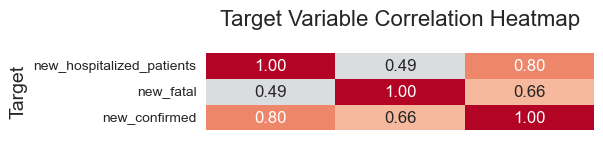

In [28]:
target_columns = ['new_hospitalized_patients', 'new_fatal', 'new_confirmed']

master_df[target_columns].corr('spearman').style.background_gradient(cmap='coolwarm')

# Plotting the heatmap
plt.figure(figsize=(5, 1))  # Adjust the figure size


ax = sns.heatmap(master_df[target_columns].corr('spearman'), 
                 cmap='coolwarm', 
                 vmin=0, 
                 vmax=1, 
                 annot=True, 
                 fmt='.2f', 
                 cbar=False)

# Positioning the x-label and xticks at the top
plt.xticks([])

# Setting labels and title
plt.xlabel(' ', fontsize=14)
plt.ylabel('Target', fontsize=14)
plt.title('Target Variable Correlation Heatmap', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [29]:
# Creating subplots vertically aligned
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Daily Confirmed", "Current Hospitalizations", "Daily Fatalities"))

# Adding traces for each subplot
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_confirmed'], name='Daily Confirmed'), row=1, col=1)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['current_hospitalized_patients'], name='Current Hospitalizations'), row=2, col=1)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_fatal'], name='Daily Fatalities'), row=3, col=1)

# Update the layout
fig.update_layout(height=800, width=1000, title='Daily Confirmed Cases, Hospitalizations, and Fatalities over Time')
fig.update_xaxes(title_text='Date', row=3, col=1)
fig.update_yaxes(title_text='Daily Confirmed Cases', row=1, col=1)
fig.update_yaxes(title_text='Daily Hospitalizations', row=2, col=1)
fig.update_yaxes(title_text='Daily Fatalities', row=3, col=1)

fig.show()


In [30]:

target_columns = ['new_hospitalized_patients', 'new_fatal', 'new_confirmed']

master_df['new_confirmed_ra'] = master_df['new_confirmed'].rolling(window=7).mean()
master_df['new_hospitalized_patients_ra'] = master_df['new_hospitalized_patients'].rolling(window=7).mean()
master_df['new_fatal_ra'] = master_df['new_fatal'].rolling(window=7).mean()

master_daily = master_df[target_columns]
master_daily.head()

,new_hospitalized_patients,new_fatal,new_confirmed
date,,,
2020-02-15,0.0,0,0
2020-02-16,0.0,0,0
2020-02-17,0.0,0,10
2020-02-18,0.0,0,0
2020-02-19,0.0,0,0


In [31]:
weekly_mean = master_df.resample('W').mean()
weekly_z_score = (weekly_mean - weekly_mean.mean()) / weekly_mean.sem()
weekly_sum = master_df.resample('W').sum()

monthly_mean = master_df.resample('M').mean()
monthly_z_score = (monthly_mean - monthly_mean.mean()) / monthly_mean.sem()
monthly_sum = master_df.resample('M').sum()



In [32]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_confirmed_ra'], name='Confirmed (7-day RA)'), secondary_y=False)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_hospitalized_patients_ra'], name='Hospitalizations (7-day RA)'), secondary_y=True)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_fatal_ra'], name='Fatalities (7-day RA)'), secondary_y=True)

# Update the layout
fig.update_layout(title='Daily Confirmed Cases vs Hospitalizations/Deaths (with 7-day Rolling Average)',
                  xaxis_title='Date',
                  yaxis_title='Daily Confirmed Cases',
                  yaxis2_title='Hospitalizations/Deaths')

fig.update_xaxes(rangeslider_visible=True)

fig.show()





In [33]:
fig = px.bar(weekly_z_score.new_confirmed)

fig.update_layout(
    yaxis_title="", 
    xaxis_title="",
    title="Monthly deviation (%)",
    showlegend=False,
)
fig.show()

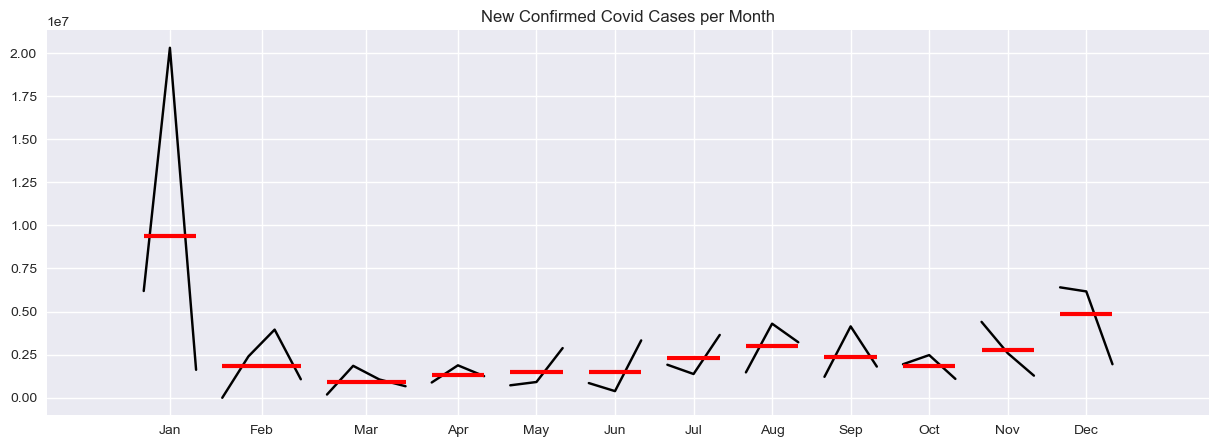

In [34]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_sum["new_confirmed"], ax=plt.gca())

plt.title("New Confirmed Covid Cases per Month")
sns.despine()
plt.show()

In [35]:
# Creating the seasonal difference again
master_df["weekly_difference"] = master_df["new_confirmed"].diff(7)

# Plotting the seasonal difference
fig = px.line(master_df, x=master_df.index, y="weekly_difference")

fig.update_layout(
    yaxis_title="Difference in Confirmed Cases", 
    xaxis_title="Date",
    title="Change in Confirmed Cases over Each Week",
    xaxis_rangeslider_visible=True,
    xaxis_range=["2021-01-31", "2023-09-01"]
)

fig.show()

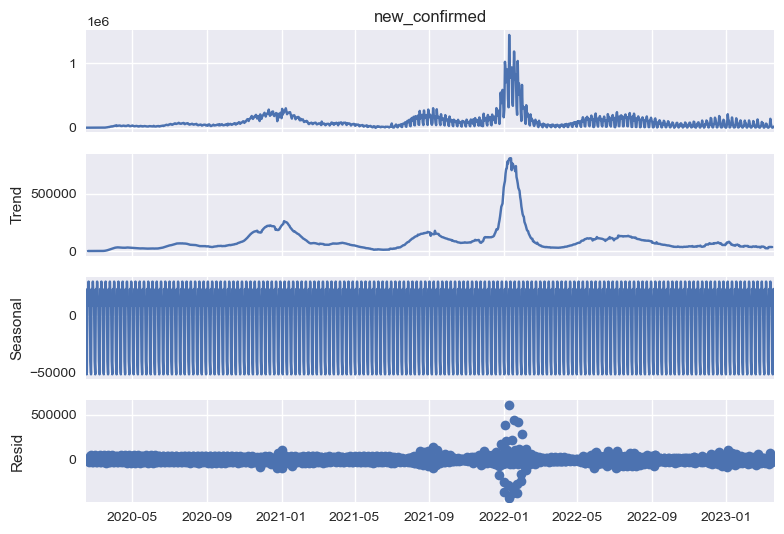

In [36]:
# Performing seasonal decomposition on 'new_confirmed' column
tsa.seasonal_decompose(master_df['new_confirmed'], model='additive', period=7).plot();



### Modeling

In [37]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

# sns.set_style('darkgrid')

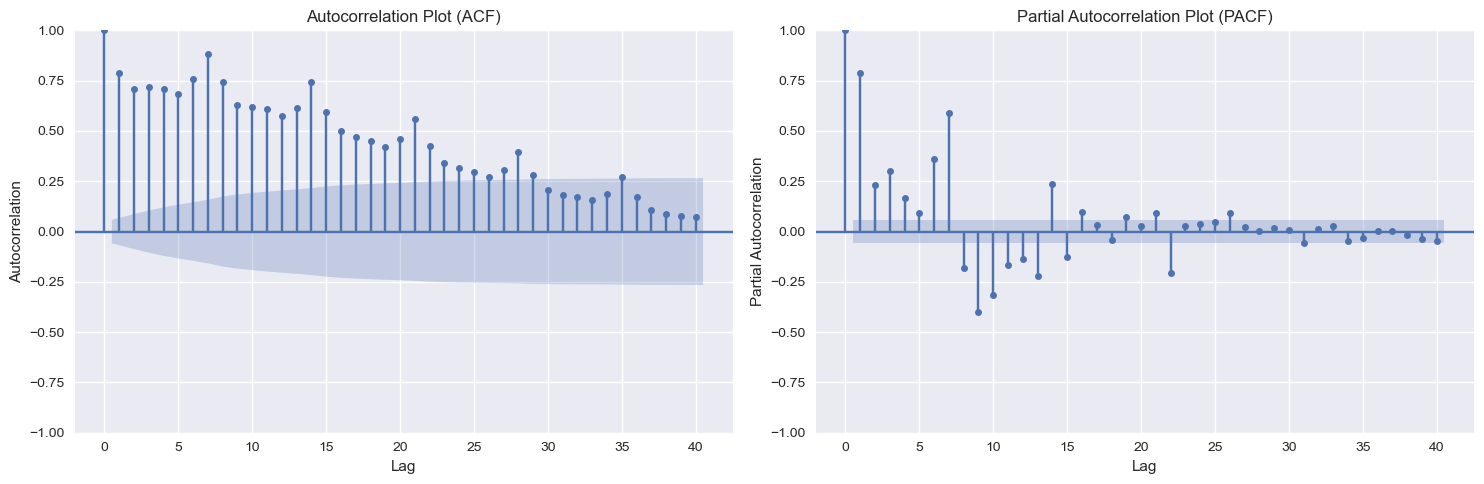

In [38]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(master_df['new_confirmed'].dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(master_df['new_confirmed'].dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


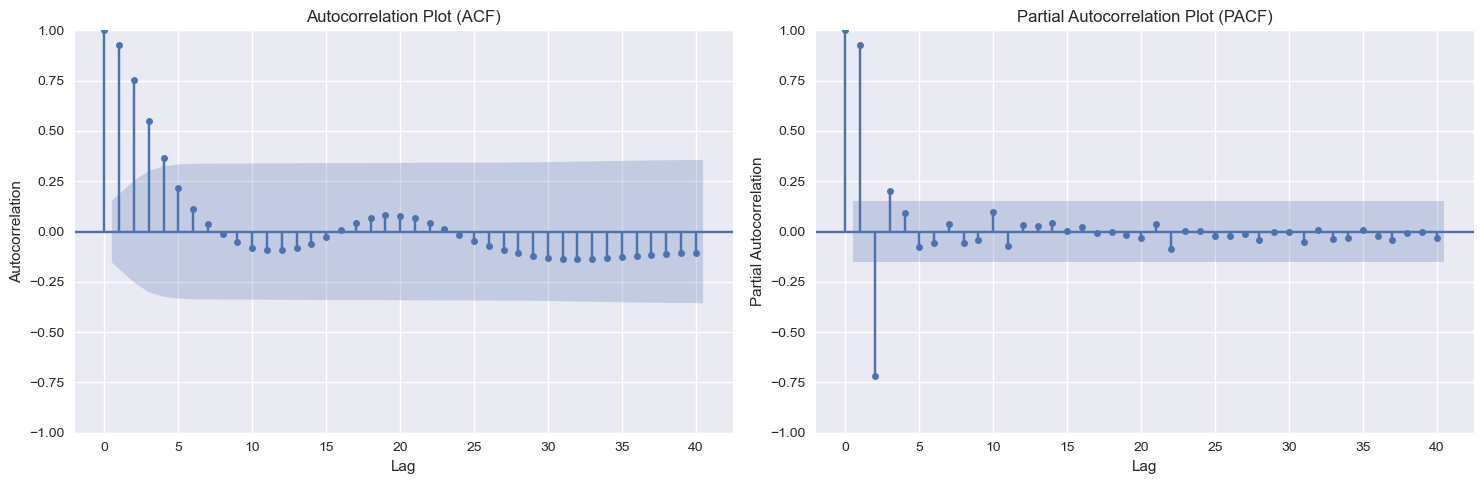

In [39]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(weekly_mean['new_confirmed'].dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(weekly_mean['new_confirmed'].dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


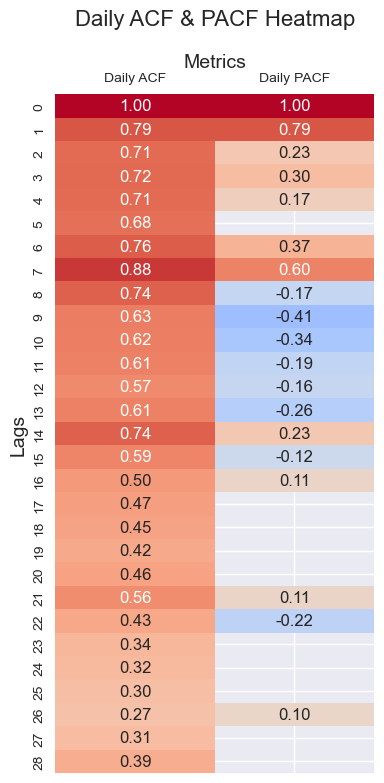

In [40]:

# Calculate ACF and PACF
ACF = acf(master_df.new_confirmed, nlags=28)
PACF = pacf(master_df.new_confirmed, nlags=28)

# Create DataFrame
daily_grid = pd.DataFrame({'Daily ACF': ACF, 'Daily PACF': PACF})

# Plotting the heatmap
plt.figure(figsize=(4, 8))  # Adjust the figure size

ax = sns.heatmap(daily_grid[np.abs(daily_grid) > .1], 
                 cmap='coolwarm', 
                 vmin=-1, 
                 vmax=1, 
                 annot=True, 
                 fmt='.2f', 
                 cbar=False)

# Positioning the x-label and xticks at the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Setting labels and title
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Lags', fontsize=14)
plt.title('Daily ACF & PACF Heatmap', fontsize=16, pad=20)

plt.tight_layout()
plt.show()


In [41]:
ACF = acf(monthly_mean.new_confirmed, nlags=12)
PACF = pacf(monthly_mean.new_confirmed, nlags=12)

monthly_grid = pd.DataFrame({'Monthly ACF': ACF, 'Monthly PACF': PACF})

monthly_grid[np.abs(monthly_grid) > .1].style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,Monthly ACF,Monthly PACF
0,1.000000,1.000000
1,0.360985,0.370741
2,nan,-0.179786
3,nan,nan
4,nan,0.110847
5,nan,nan
6,nan,-0.125027
7,-0.130902,nan
8,-0.134844,-0.112153
9,-0.121022,-0.115237


### <a id='toc1_2_2_'></a>[Basic EDA: Bivariate Analysis](#toc0_)

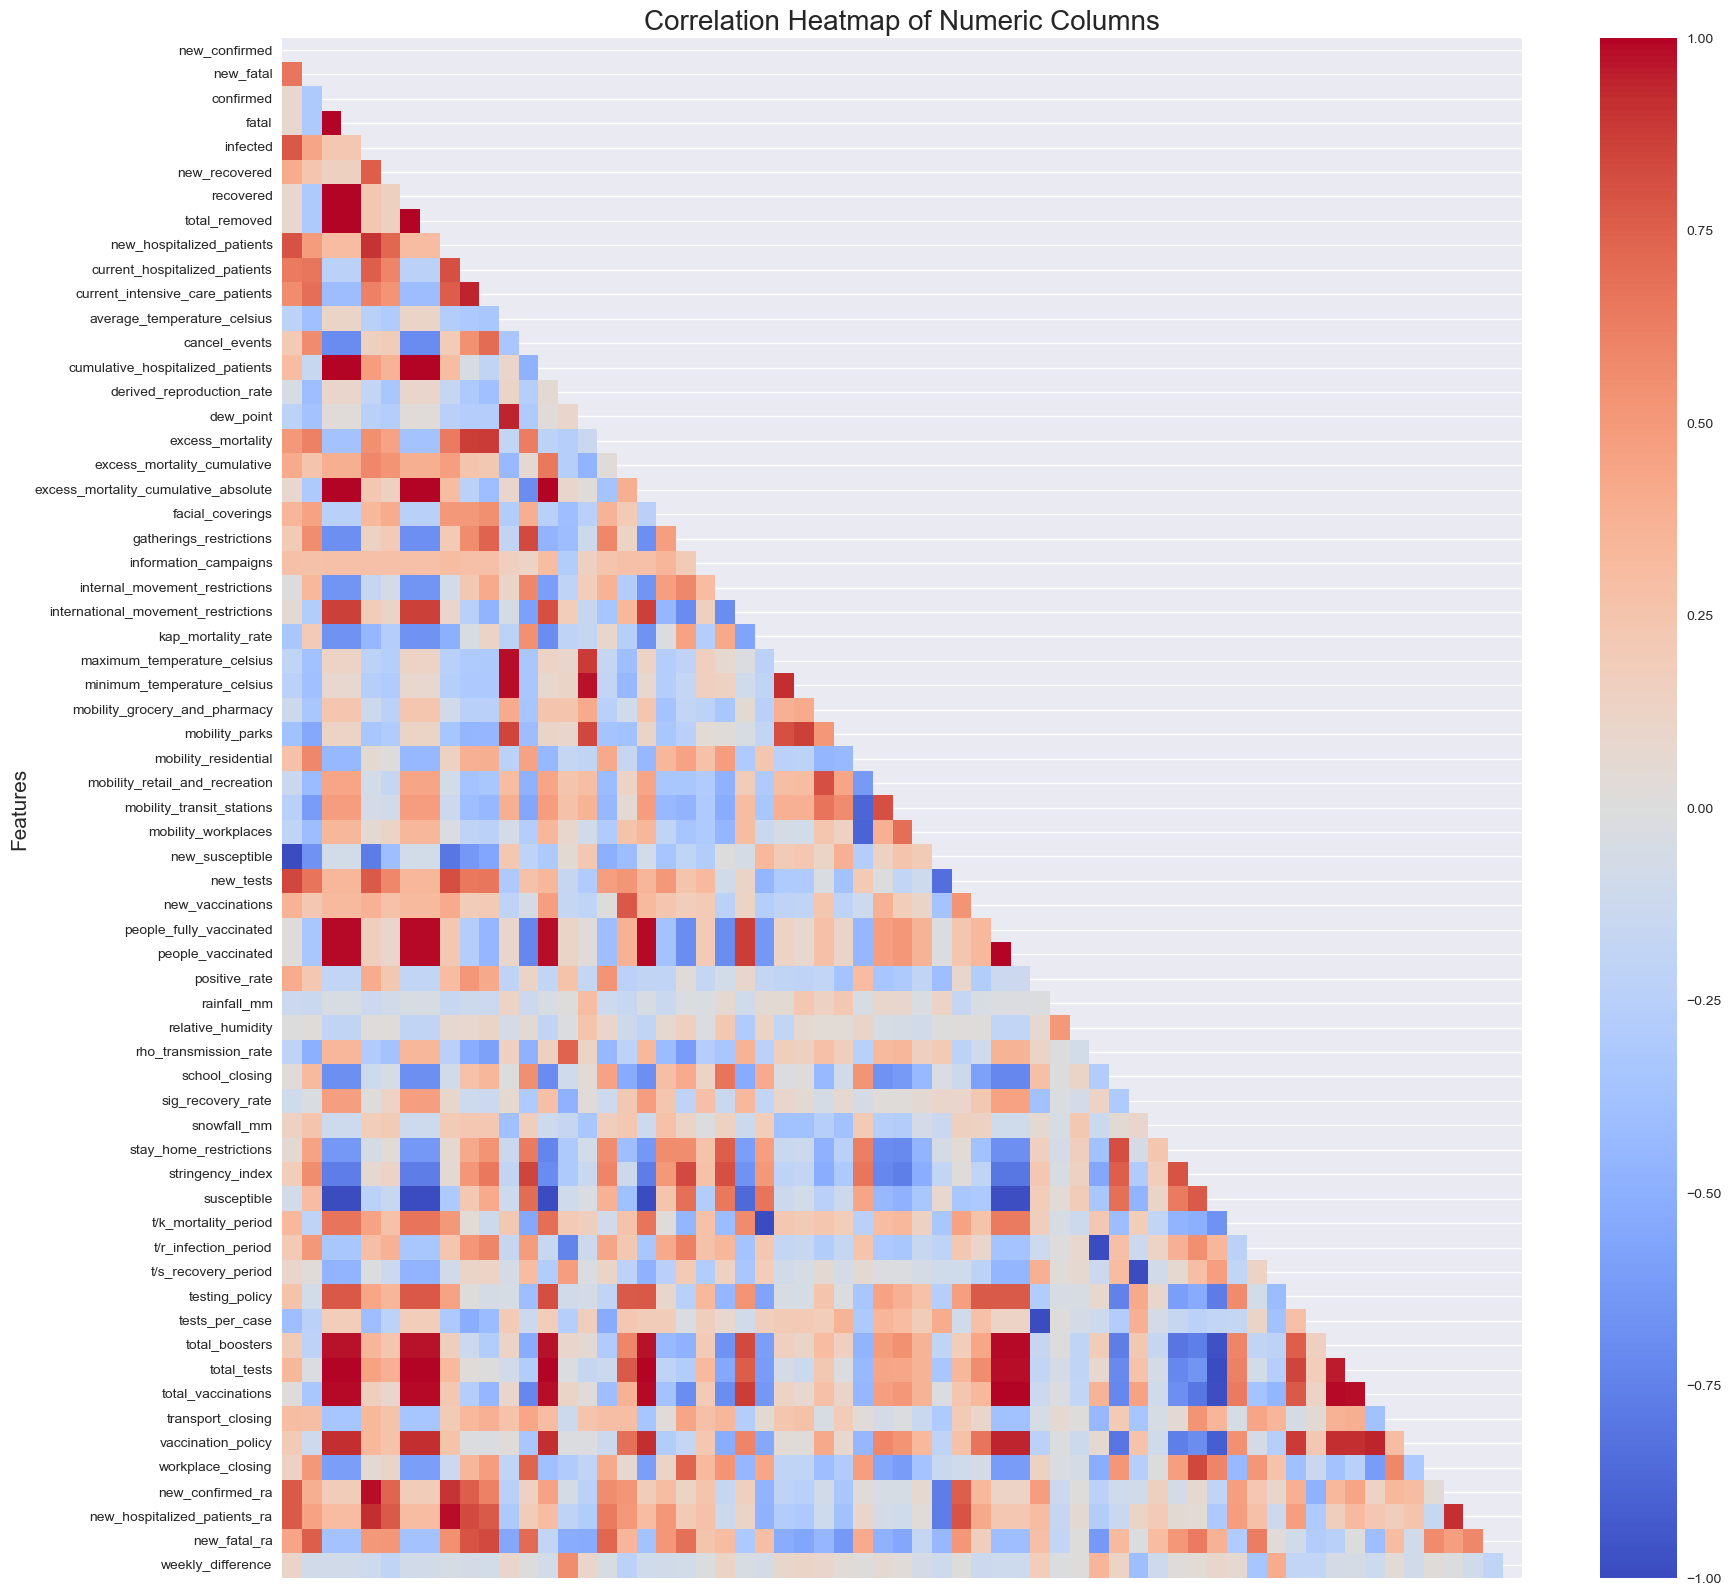

In [42]:
# Compute the correlation matrix for the Iris DataFrame. This will give us the correlation coefficient between every pair of features (including the target).
# Calculate all the correlations between each independent variables
corr_df = master_df.corr('spearman')

# Mask for upper-triangular
mask = np.triu(corr_df)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)
plt.title('Correlation Heatmap of Numeric Columns', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xticks([])
plt.show()

# Display the correlation matrix, transposed for readability and sorted by the 'target' column. This gives us an idea of which features are most strongly correlated with the target.
# The 'style.background_gradient' method is used to apply a color gradient to the 'target' column, making it easier to visually identify high and low correlation values.
# display(correlation.T.sort_values('target').style.background_gradient(subset='target', cmap='coolwarm'))


$$R_0 = \frac{\text{transmission rate}}{\text{recovery rate} + \text{mortality rate}}$$

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


redundant_features = ['new_confirmed', 'fatal', 'recovered', 'confirmed', 'people_fully_vaccinated', 'excess_mortality_cumulative_absolute', 'susceptible', 'excess_mortality_cumulative',
                                    'infected', 'total_removed', 'new_susceptible', 'people_vaccinated', 'international_movement_restrictions', 'workplace_closing',
                                    'information_campaigns', 'cancel_events', 'gatherings_restrictions', 'current_intensive_care_patients', 
                                    'testing_policy', 'stay_home_restrictions', 'new_vaccinations', 'school_closing','internal_movement_restrictions', 
                                    't/r_infection_period', 't/s_recovery_period', 't/k_mortality_period', 'new_recovered']

# Assuming in_sample_set is a DataFrame
# Add a constant term to the predictor variables for the intercept
X = add_constant(master_df.dropna(axis=1)).drop(columns=redundant_features)

# Create a DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data.sort_values(by='VIF', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))


,Feature,VIF
0,const,200.168689
8,stringency_index,8.836312
3,derived_reproduction_rate,8.209422
2,current_hospitalized_patients,6.882715
4,excess_mortality,6.020667
9,total_vaccinations,5.248650
5,kap_mortality_rate,3.634132
6,rho_transmission_rate,2.679168
7,sig_recovery_rate,2.565097
1,new_fatal,1.931130


In [44]:
master_df.corr('spearman')['new_confirmed']\
    .sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')




,new_confirmed
new_confirmed,1.000000
new_tests,0.835253
new_hospitalized_patients,0.795200
infected,0.780973
new_confirmed_ra,0.774539
new_hospitalized_patients_ra,0.765976
new_fatal,0.662512
current_hospitalized_patients,0.643971
current_intensive_care_patients,0.559187
excess_mortality,0.501404


## <a id='toc1_3_'></a>[Insights and Conclusions](#toc0_)

Based on the univariate and bivariate analysis we performed on the Iris dataset, we can make the following observations:

1. **Univariate Analysis**: The variables 'sepal_width', 'sepal_length', 'petal_width', and 'petal_length' all follow a somewhat normal distribution, with some having a slightly skewed distribution. The 'species' variable, which is categorical, has an equal distribution of classes, meaning we have a balanced dataset.

2. **Bivariate Analysis**: The correlation matrix and pairplot give us an idea of the relationship between variables. 'Petal_length' and 'petal_width' show a strong positive correlation, meaning they increase together. Similarly, 'sepal_length' and 'petal_length' as well as 'sepal_length' and 'petal_width' show a strong positive correlation. 'Sepal_length' and 'sepal_width' show a negative correlation, meaning as one increases, the other decreases. These correlations indicate that petal measurements may be a good predictor of species type.

3. **Clustering Analysis**: KMeans clustering was performed on the data and it grouped the data into three clusters. When we compare these clusters with the original 'species' labels, we can see a good overlap, which indicates that the clusters formed are meaningful and reflect the natural groupings in the data. However, there are some misclassifications, particularly between the Versicolor and Virginica species. This could be due to the fact that these two species are more similar to each other in terms of sepal and petal measurements compared to the Setosa species, which is more distinct.

In conclusion, this analysis shows that the Iris dataset has meaningful and significant patterns that can be captured using statistical analysis and machine learning techniques. These patterns are reflective of the underlying biological differences between different species of Iris flowers.